In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import tqdm
tqdm.tqdm_notebook()

|<bar/>| 0/? [00:00<?, ?it/s]

### Fetch peak predictions and original BED files

In [2]:
tf_name = "E2F6"
predictions_path = "/users/amtseng/tfmodisco/results/peak_predictions/{0}/{0}_peak_prediction_performance.h5".format(tf_name)
fold = 1
chrom_set = ["chr1"]

In [3]:
pred_reader = h5py.File(predictions_path, "r")

In [4]:
bed_dir_path = "/users/amtseng/tfmodisco/data/raw/ENCODE/%s/tf_chipseq/" % tf_name
peak_bed_paths = []
for item in os.listdir(bed_dir_path):
    if "optimal" in item and item.endswith(".bed.gz"):
        peak_bed_paths.append(os.path.join(bed_dir_path, item))

### Import the peaks
Test set only, and sort in the order of the coordinates in the predictions

In [5]:
peaks = []
for peak_bed_path in peak_bed_paths:
    table = pd.read_csv(
        peak_bed_path, sep="\t", header=None,  # Infer compression
        names=[
            "chrom", "peak_start", "peak_end", "name", "score",
            "strand", "signal", "pval", "qval", "summit_offset"
        ]
    )
    table = table[table["chrom"].isin(chrom_set)]
    peaks.append(table)
peaks = pd.concat(peaks)
peaks = peaks.sort_values("signal", ascending=False).reset_index(drop=True)

In [6]:
# Add a column for the summit location
peaks["summit_loc"] = peaks["peak_start"] + peaks["summit_offset"]

In [7]:
# Check that the coordinates in the predictions and peak table are the same
coords = pred_reader["fold%d" % fold]["coords"]
coords_arr = np.empty((2, len(peaks)), dtype=object)
coords_arr[0] = coords["coords_chrom"][:].astype(str)
coords_arr[1] = (coords["coords_start"][:] + coords["coords_end"]) // 2
assert np.all(coords_arr[0] == peaks["chrom"].values.astype(str))
assert np.all(np.sort(coords_arr[1]) == np.sort(peaks["summit_loc"].values))

In [8]:
# Order the peak table to be in the same order as the coordinates
inds = []
for loc in tqdm.notebook.tqdm(coords_arr[1]):
    inds.append(np.where(peaks["summit_loc"].values == loc)[0][0])
peaks = peaks.iloc[inds].reset_index(drop=True)

In [9]:
# Check the ordering is all the same
assert np.all(coords_arr[0] == peaks["chrom"].values.astype(str))
assert np.all(coords_arr[1] == peaks["summit_loc"].values)

### Compare signal strength to performance metrics

In [10]:
preds = pred_reader["fold%d" % fold]["predictions"]
perfs = pred_reader["fold%d" % fold]["performance"]

In [11]:
perfs.keys()

<KeysViewHDF5 ['count_mse', 'count_pearson', 'count_spearman', 'jsd', 'nll', 'profile_mse', 'profile_pearson', 'profile_spearman']>

In [12]:
preds["true_counts"]

<HDF5 dataset "true_counts": shape (5750, 2, 2), type "<f8">

In [13]:
perfs["nll"]

<HDF5 dataset "nll": shape (5750, 2), type "<f8">

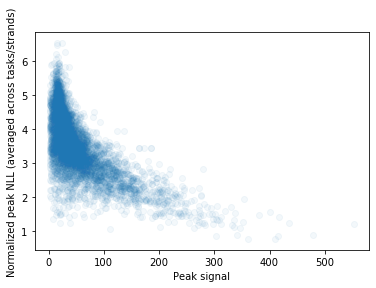

In [14]:
plt.figure()
plt.scatter(peaks["signal"], np.mean(perfs["nll"] / np.mean(preds["true_counts"][:], axis=2), axis=1), alpha=0.05)
plt.xlabel("Peak signal")
plt.ylabel("Normalized peak NLL (averaged across tasks/strands)")
plt.show()

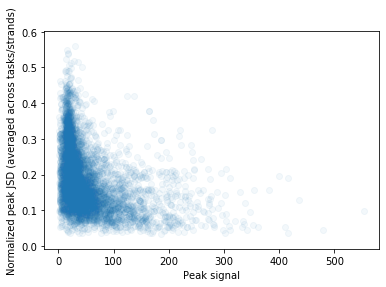

In [15]:
plt.figure()
plt.scatter(peaks["signal"], np.mean(perfs["jsd"], axis=1), alpha=0.05)
plt.xlabel("Peak signal")
plt.ylabel("Normalized peak JSD (averaged across tasks/strands)")
plt.show()

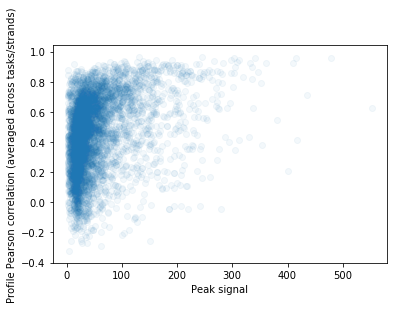

In [16]:
plt.figure()
plt.scatter(peaks["signal"], np.mean(perfs["profile_pearson"], axis=1), alpha=0.05)
plt.xlabel("Peak signal")
plt.ylabel("Profile Pearson correlation (averaged across tasks/strands)")
plt.show()

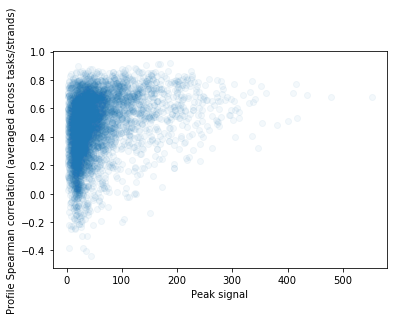

In [17]:
plt.figure()
plt.scatter(peaks["signal"], np.mean(perfs["profile_spearman"], axis=1), alpha=0.05)
plt.xlabel("Peak signal")
plt.ylabel("Profile Spearman correlation (averaged across tasks/strands)")
plt.show()

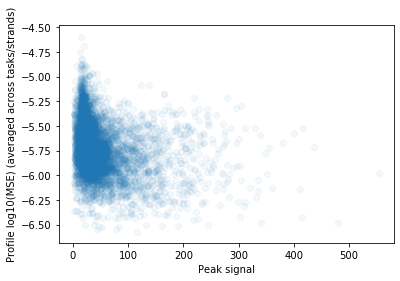

In [18]:
plt.figure()
plt.scatter(peaks["signal"], np.mean(np.log10(perfs["profile_mse"]), axis=1), alpha=0.05)
plt.xlabel("Peak signal")
plt.ylabel("Profile log10(MSE) (averaged across tasks/strands)")
plt.show()